In [618]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
from optbinning import OptimalBinning
from typing import List, Optional, Union
import pnlp

import category_encoders as ce
warnings.filterwarnings('ignore')

In [2]:
train_file = "/Users/HaoShaochun/Yam/FinancialRiskControl/data/train.csv"
test_file = "/Users/HaoShaochun/Yam/FinancialRiskControl/data/testA.csv"

data_train = pd.read_csv(train_file)
data_test = pd.read_csv(test_file)

## 预处理

In [270]:
def drop_given_features(df: pd.DataFrame, feature_list: List[str]) -> pd.DataFrame:
    return df.drop(columns=feature_list)

def drop_uniquevalue_features(df: pd.DataFrame) -> pd.DataFrame:
    need_drop_feas = [col for col in df.columns if df[col].nunique() <= 1]
    return df.drop(columns=need_drop_feas)

def convert_num_to_obj(x: Union[int, float]):
    if pd.notna(x):
        return str(int(x))
    else:
        return ""

def deal_employmentLength(x):
    if pd.notna(x):
        if x == "10+ years":
            return 10.0
        elif x == "< 1 year":
            return 0.5
        else:
            return float(x[0])
    else:
        return np.nan
insignificant_feas = ["id", "issueDate", "title"]
grade_dct = dict(zip(['A', 'B', 'C', 'D', 'E', 'F', 'G'], range(10, 80, 10)))

In [272]:
data_train = drop_given_features(data_train, insignificant_feas)
data_train = drop_uniquevalue_features(data_train)

In [299]:
data_train['grade'] = data_train['grade'].map(grade_dct)
data_train["subGrade"] = \
data_train["subGrade"].apply(lambda x: grade_dct.get(x[0]) + int(x[1]))

In [323]:
data_train["employmentTitle"] = \
data_train["employmentTitle"].apply(convert_num_to_obj)

In [329]:
data_train["employmentLength"] = \
data_train["employmentLength"].apply(deal_employmentLength)

In [338]:
data_train["homeOwnership"] = \
data_train["homeOwnership"].apply(convert_num_to_obj)

data_train["verificationStatus"] = \
data_train["verificationStatus"].apply(convert_num_to_obj)

data_train["purpose"] = \
data_train["purpose"].apply(convert_num_to_obj)

data_train["postCode"] = \
data_train["postCode"].apply(convert_num_to_obj)

data_train["regionCode"] = \
data_train["regionCode"].apply(convert_num_to_obj)

data_train["earliesCreditLine"] = \
data_train["earliesCreditLine"].apply(lambda x: int(x[-4:]))

data_train["n11"] = \
data_train["n11"].apply(convert_num_to_obj)
data_train["n12"] = \
data_train["n12"].apply(convert_num_to_obj)

In [464]:
zero_one_feas = [
    "initialListStatus", "applicationType", 
]
num_not_bucket_feas = [
    "term", "grade", "subGrade", "employmentLength", 
]
num_need_bucket_feas = [
    "loanAmnt", "interestRate", "installment", "dti", 
    "delinquency_2years",
    "ficoRangeLow", "ficoRangeHigh", 
    "openAcc", 
    "pubRec", "pubRecBankruptcies",
    "revolBal", "revolUtil", "totalAcc",
    "earliesCreditLine", 
    "n0", "n1", "n2", "n2.1", 
    'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n13', 'n14'
    
]
obj_not_bucket_feas = [
    "homeOwnership", "verificationStatus", "purpose", "n11", "n12"
]
obj_need_bucket_feas = [
    "employmentTitle", "postCode", "regionCode"
]

In [468]:
fea = "initialListStatus"

In [469]:
data_train[fea].describe()

count    800000.000000
mean          0.416953
std           0.493055
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: initialListStatus, dtype: float64

In [470]:
data_train[fea].value_counts()

0    466438
1    333562
Name: initialListStatus, dtype: int64

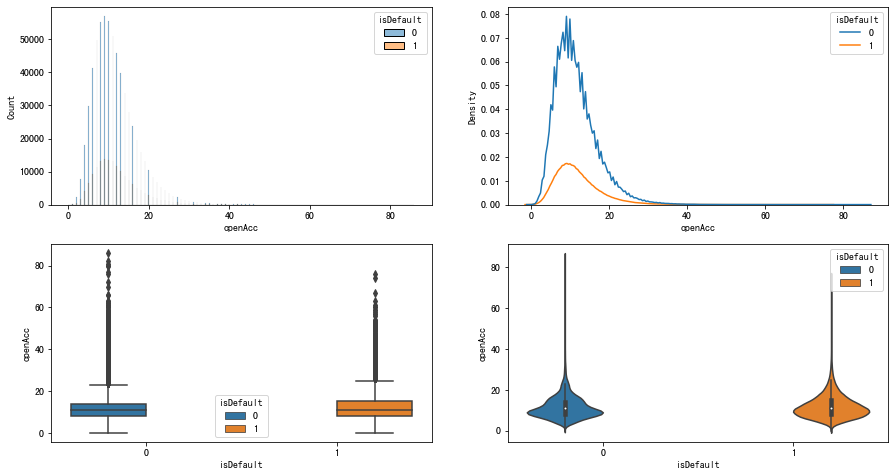

In [384]:
plot_feature_distribution(
    data_train, "openAcc", hue="isDefault")

In [346]:
def plot_feature_distribution(df: pd.DataFrame, feature: str, hue: Optional[str] = None):
    rows = 2
    if hue:
        hue = df[hue]
        
    fig, axs = plt.subplots(nrows=rows, ncols=2, figsize=(15, 4*rows))
    
    sns.histplot(x=df[feature], hue=hue, ax=axs[0, 0])
    sns.kdeplot(x=df[feature], hue=hue, ax=axs[0, 1])
    
    sns.boxplot(x=hue, y=df[feature], hue=hue, ax=axs[1, 0])
    sns.violinplot(x=hue, y=df[feature], hue=hue, ax=axs[1, 1])

In [662]:
def plot_feature_relations(df: pd.DataFrame, x: str, y: str, hue: str):
    if hue:
        hue = df[hue]
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    sns.scatterplot(x=df[x], y=df[y], hue=hue, ax=axs[0])
    sns.lineplot(x=df[x], y=df[y], hue=hue, ax=axs[1])

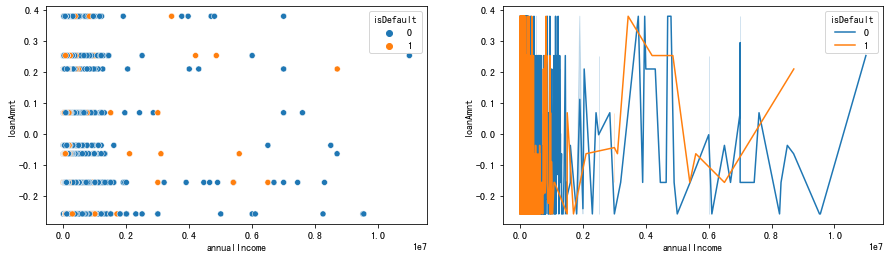

In [663]:
plot_feature_relations(data_train, "annualIncome", "loanAmnt", "isDefault")

## 分箱

In [472]:
print(num_need_bucket_feas)

['loanAmnt', 'interestRate', 'installment', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc', 'earliesCreditLine', 'n0', 'n1', 'n2', 'n2.1', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n13', 'n14']


In [474]:
for fea in num_need_bucket_feas:
    optb = OptimalBinning(name=fea, dtype="numerical", solver="cp")
    optb.fit(data_train[fea], data_train["isDefault"])
    data_train[fea] = optb.transform(data_train[fea])

In [478]:
print(obj_need_bucket_feas)

['employmentTitle', 'postCode', 'regionCode']


In [529]:
def categorical_binning(
    data: pd.DataFrame, fea: str, cat_cutoff: float):
    optb = OptimalBinning(name=fea, dtype="categorical", 
                      prebinning_method='quantile', 
                      solver="mip", cat_cutoff=cat_cutoff)
    optb.fit(data[fea], data["isDefault"])
    data[fea] = optb.transform(data[fea])
    return data

In [530]:
data_train = categorical_binning(data_train, "employmentTitle", 0.05)
data_train = categorical_binning(data_train, "postCode", 0.01)
data_train = categorical_binning(data_train, "regionCode", 0.1)

In [542]:
for key,val in data_train.isnull().sum().to_dict().items():
    if val > 0:
        print(key, val)

employmentLength 46799


In [544]:
data_train["employmentLength"] = \
data_train["employmentLength"].fillna(
    data_train["employmentLength"].mean())

In [547]:
data_train.isna().sum().any().sum()

0

## 类别编码

In [550]:
print(obj_not_bucket_feas)

['homeOwnership', 'verificationStatus', 'purpose', 'n11', 'n12']


In [551]:
data_train = pd.get_dummies(
    data_train, 
    columns=obj_not_bucket_feas, 
    drop_first=True)

In [554]:
data_train.shape

(800000, 68)

## 汇总

In [605]:
data_train = pd.read_csv(train_file)
data_test = pd.read_csv(test_file)

In [606]:
def process_data(
    data: pd.DataFrame, 
    num_optbs: list = [], 
    obj_optbs: list = [], 
    training_data: bool = True):
    
    if training_data:
        num_optbs = []
        obj_optbs = []
    else:
        assert len(num_optbs) > 0
        assert len(obj_optbs) > 0
    
    data = drop_given_features(data, insignificant_feas)
    data = drop_uniquevalue_features(data)
    data['grade'] = data['grade'].map(grade_dct)
    data["subGrade"] = \
    data["subGrade"].apply(lambda x: grade_dct.get(x[0]) + int(x[1]))
    data["employmentTitle"] = \
    data["employmentTitle"].apply(convert_num_to_obj)
    data["employmentLength"] = \
    data["employmentLength"].apply(deal_employmentLength)
    data["homeOwnership"] = \
    data["homeOwnership"].apply(convert_num_to_obj)

    data["verificationStatus"] = \
    data["verificationStatus"].apply(convert_num_to_obj)

    data["purpose"] = \
    data["purpose"].apply(convert_num_to_obj)

    data["postCode"] = \
    data["postCode"].apply(convert_num_to_obj)

    data["regionCode"] = \
    data["regionCode"].apply(convert_num_to_obj)

    data["earliesCreditLine"] = \
    data["earliesCreditLine"].apply(lambda x: int(x[-4:]))

    data["n11"] = \
    data["n11"].apply(convert_num_to_obj)
    data["n12"] = \
    data["n12"].apply(convert_num_to_obj)

    
    for i, fea in enumerate(num_need_bucket_feas):
        if training_data:
            optb = OptimalBinning(name=fea, dtype="numerical", solver="cp")
            optb.fit(data[fea], data["isDefault"])
            num_optbs.append(optb)
        else:
            optb = num_optbs[i]
        data[fea] = optb.transform(data[fea])
    
    
    cutoffs = [0.05, 0.01, 0.1]
    for i, fea in enumerate(obj_need_bucket_feas):
        cutoff = cutoffs[i]
        if training_data:
            optb = OptimalBinning(
                name=fea, dtype="categorical", prebinning_method='quantile', solver="mip", cat_cutoff=cutoff)
            optb.fit(data[fea], data["isDefault"])
            obj_optbs.append(optb)
        else:
            optb = obj_optbs[i]
        data[fea] = optb.transform(data[fea])
    
    data["employmentLength"] = \
    data["employmentLength"].fillna(data["employmentLength"].mean())
    data = pd.get_dummies(data, columns=obj_not_bucket_feas, drop_first=True)
    
    if training_data:
        return data, num_optbs, obj_optbs
    else:
        return data

In [607]:
data_train, num_optbs, obj_optbs = process_data(data_train)

In [609]:
data_test = process_data(data_test, num_optbs, obj_optbs, False)

In [608]:
data_train.shape

(800000, 68)

In [610]:
data_test.shape

(200000, 67)

## Base 建模

In [613]:
features = [fea for fea in list(data_train.columns) if fea not in  ["isDefault", "n11_4", "n12_4"]]

In [614]:
x_train = data_train[features]
x_test = data_test[features]
y_train = data_train['isDefault']

In [615]:
def cv_model(clf, train_x, train_y, test_x, clf_name):
    folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs':24,
                'silent': True,
                'verbose': -1,
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': 'exact',
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(test_x , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
            
        train[valid_index] = val_pred
        test = test_pred / kf.n_splits
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
        print(cv_scores)
        
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    return train, test

In [616]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test

def cat_model(x_train, y_train, x_test):
    cat_train, cat_test = cv_model(CatBoostRegressor, x_train, y_train, x_test, "cat")

In [617]:
lgb_train, lgb_test = lgb_model(x_train, y_train, x_test)

************************************ 1 ************************************
[LightGBM] [Warning] num_threads is set with n_jobs=24, nthread=28 will be ignored. Current value: num_threads=24
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.735135	valid_1's auc: 0.725531
[400]	training's auc: 0.745193	valid_1's auc: 0.726157
[600]	training's auc: 0.754403	valid_1's auc: 0.726198
Early stopping, best iteration is:
[484]	training's auc: 0.749219	valid_1's auc: 0.726315
[0.7263147866629363]
************************************ 2 ************************************
[LightGBM] [Warning] num_threads is set with n_jobs=24, nthread=28 will be ignored. Current value: num_threads=24
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.736408	valid_1's auc: 0.721384
[400]	training's auc: 0.74638	valid_1's auc: 0.722207
[600]	training's 

In [623]:
test_out_file = "/Users/HaoShaochun/Yam/FinancialRiskControl/data/testA_result.csv"

data_pred = pd.read_csv(test_file)

out = ["id,isDefault"]
ids = list(data_pred.id)
for i in range(len(lgb_test)):
    line = str(ids[i]) + "," + str(lgb_test[i])
    out.append(line)

pnlp.write_file(test_out_file, out)

In [648]:
# 成绩 0.7191